# Bagging, Random Forests and Boosting for Classification
### Predicting Credit Card Default

### Data Set Information:

**This research aimed at the case of customers default payments in Taiwan**

### Features description:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- SEX: Gender (1 = male; 2 = female). 
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
- AGE: Age (year). 
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar).
- default payment next month: **positive class: default | negative class: pay**

In [1]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Data Preparation

In [2]:
default = pd.read_csv('../data/credit_card_default.csv', index_col="ID")
default.rename(columns=lambda x: x.lower(), inplace=True)
default.rename(columns={'pay_0':'pay_1','default payment next month':'default'}, inplace=True)
# Base values: female, other_education, not_married
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default['male'] = (default['sex']==1).astype('int')
default['married'] = (default['marriage'] == 1).astype('int')

default.drop(['sex','marriage', 'education'], axis=1, inplace=True)

# For pay_i features: if >0 then it means the customer was delayed i months ago
pay_features = ['pay_' + str(i) for i in range(1,7)]
for p in pay_features:
    default[p] = (default[p] > 0).astype(int)

In [3]:
default.head()

,limit_bal,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,1,1,0,0,0,0,3913,3102,...,0,0,0,0,1,0,1,0,0,1
2,120000,26,0,1,0,0,0,1,2682,1725,...,1000,1000,0,2000,1,0,1,0,0,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,0,0,1,0,0,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,0,0,1,0,0,1
5,50000,57,0,0,0,0,0,0,8617,5670,...,10000,9000,689,679,0,0,1,0,1,1


# Building models using all features

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [5]:
target_name = 'default'
X = default.drop('default', axis=1)
feature_names = X.columns
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=55, stratify=y)

In [6]:
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

### Preparing a DataFrame for model analysis

In [7]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision' ,'recall'], 
                      columns=['LogisticReg', 'Bagging', 'RandomForest', 'Boosting'])

- **Accuracy**: the proportion of the total number of predictions that are correct
- **Precision**: the proportion of positive predictions that are actually correct
- **Recall**: the proportion of positive observed values correctly predicted as such

**In this application:**
- **Accuracy**: Overall how often the model predicts correctly defaulters and non-defaulters
- **Precision**: When the model predicts **default**: how often is correct?
- **Recall**: The proportion of **actual defalters** that the model will correctly predict as such

#### Which metric should I use?

- **False Positive**: A person who will pay predicted as defaulter
- **False Negative**: A person who default predicted as payer

#### False negatives are worse => look for a better recall

## A. Logistic Regression

In [8]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(random_state=55)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3315,190,3505
default,684,311,995
Total,3999,501,4500


## B. Bagging

In [9]:
# 1. Import the estimator object (model)
from sklearn.ensemble import BaggingClassifier

# 2. Create an instance of the estimator
log_reg_for_bagging = LogisticRegression()
bagging = BaggingClassifier(base_estimator=log_reg_for_bagging, n_estimators=10,
                            random_state=55, n_jobs=-1)

# 3. Use the trainning data to train the estimator
bagging.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = bagging.predict(X_test)
metrics.loc['accuracy','Bagging'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','Bagging'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','Bagging'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3312,193,3505
default,683,312,995
Total,3995,505,4500


## C. Random Forests

In [10]:
# 1. Import the estimator object (model)
from sklearn.ensemble import RandomForestClassifier

# 2. Create an instance of the estimator
RF = RandomForestClassifier(n_estimators=35, max_depth=20, random_state=55, max_features='sqrt',
                            n_jobs=-1)

# 3. Use the trainning data to train the estimator
RF.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = RF.predict(X_test)
metrics.loc['accuracy','RandomForest'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','RandomForest'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','RandomForest'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3276,229,3505
default,625,370,995
Total,3901,599,4500


## D. Boosting

In [11]:
# 1. Import the estimator object (model)
from sklearn.ensemble import AdaBoostClassifier

# 2. Create an instance of the estimator
boosting = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=55)    

# 3. Use the trainning data to train the estimator
boosting.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = boosting.predict(X_test)
metrics.loc['accuracy','Boosting'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','Boosting'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','Boosting'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3347,158,3505
default,724,271,995
Total,4071,429,4500


In [12]:
100*metrics

,LogisticReg,Bagging,RandomForest,Boosting
accuracy,80.5778,80.5333,81.0222,80.4
precision,62.0758,61.7822,61.7696,63.1702
recall,31.2563,31.3568,37.1859,27.2362


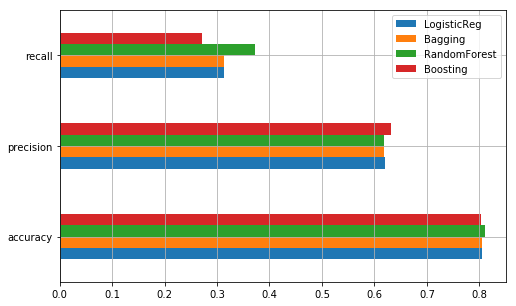

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [14]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=RF.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                                                probas_pred=logistic_regression.predict_proba(X_test)[:,1])

### Confusion matrix for modified Logistic Regression Classifier

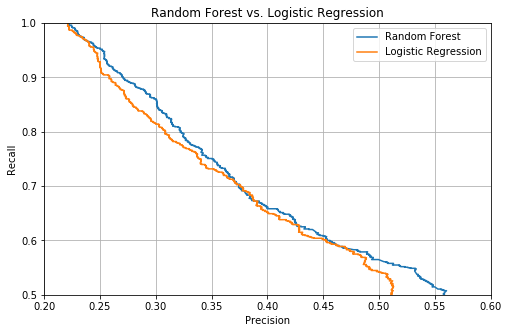

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_rf, recall_rf, label='Random Forest')
ax.plot(precision_lr,recall_lr , label='Logistic Regression')
ax.set_ylim(0.5,1)
ax.set_xlim(0.2,0.6)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Random Forest vs. Logistic Regression')
ax.legend()
ax.grid();

### Random Forest classifier with threshold of 0.12

In [28]:
y_pred_proba = RF.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.12).astype('int')
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*round(recall_score(y_pred=y_pred_test, y_true=y_test),2))
print("Precision: ", 100*round(precision_score(y_pred=y_pred_test, y_true=y_test),2))
CMatrix(CM)

Recall:  84.0
Precision:  30.0


PREDICTION,pay,default,Total
TRUE,,,
pay,1601,1904,3505
default,160,835,995
Total,1761,2739,4500


## Feature importance

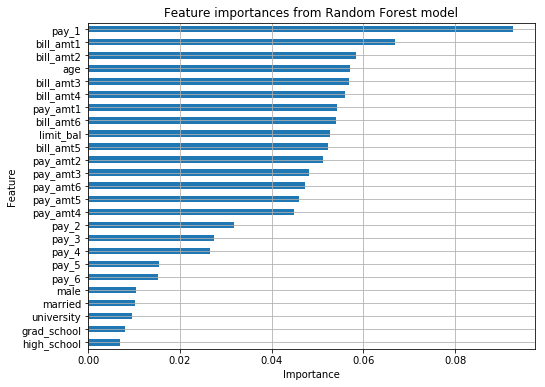

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
feature_importances = pd.Series(data=RF.feature_importances_, index=feature_names)
feature_importances.sort_values().plot(kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature importances from Random Forest model')
ax.grid();